# Assignment 7: Transfer Learning


The goal of this exercise is to learn how to use pre-trained networks in transfer learning tasks.
We will make use of networks trained on ImageNet, and apply them to related problems, i.e., the classification of $10$ objects not contained in ImageNet.

## Dataset

For this exercise we use the  [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset that can be downloaded from the official website [here]({https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz}).
The dataset contains $60000$ color images of pixels size $32\times 32$ in $10$ classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck, with $6000$ images per class.

### Task 1: Data Transformation

We need to instantiate a proper `torchvision.transform` instance to create the same input structure as used for training our network.
We need to combine 4 transforms, which can be compiled from the PyTorch website: https://pytorch.org/vision/stable/models.html

1. We need to resize the image such that the shorter side has size 256.
2. We need to take the center crop of size $224\times224$ from the image.
3. We need to convert the image into a tensor (including pixel values scaling)
4. We need to normalize the pixel values with mean $(0.485, 0.456, 0.406)$ and standard deviation $(0.229, 0.224, 0.225)$.

Since we will use networks pre-trained on ImageNet, we need to perform the exact same transform as used for ImageNet testing.

In [ ]:
import torch
import torchvision

# Apply it to the input image
imagenet_transform = torchvision.transforms.Compose(
  [torchvision.transforms.Resize(256), # resize the image such that the shorter side has size 256.
  torchvision.transforms.CenterCrop(224), # take the center crop of size 224*224 from the image.
  torchvision.transforms.ToTensor(), # convert the image into a tensor (including pixel values scaling)
  torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))] # normalize the pixel values with mean (0.485, 0.456, 0.406) and sd (0.229, 0.224, 0.225).
)

### Task 2: Dataset Loading

We here use the [torchvision.datasets.CIFAR10](https://pytorch.org/vision/0.12/generated/torchvision.datasets.CIFAR10.html) dataset interface for processing images. 
You can use the `train` argument or flag to distinguish between training and test set.

This task consists of two parts:

1. Create two datasets, one for the training set, one for the test set. Use the transform defined above.
2. Once the datasets are created, create two data loaders, one for training set, one for test set. Use a proper value of the batch-size $B$.

In [ ]:
trainset = torchvision.datasets.CIFAR10(
  root = "./data",
  train=True, download=True, transform=imagenet_transform
)

testset = torchvision.datasets.CIFAR10(
  root = "./data",
  train=False, download=True, transform=imagenet_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# https://github.com/hyunjoonbok/Python-Projects/blob/master/Pytorch/Transfer%20Learning%20in%20Pytorch%20by%20building%20CIFAR-10%20model.ipynb
B = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=B, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=B, shuffle=False)

### Test 1: Data Size and Types

We check that all input images are `torch.tensors` of size $3\times224\times224$ and of type `torch.float` and that all labels are of type `int`.

Note: the sanity check is only performed on the test set.

In [ ]:
for x, t in testset:
  assert isinstance(x, torch.Tensor)
  assert isinstance(t, int)
  assert x.shape==(3,224,224)
  assert x.dtype==torch.float

### Task 3: Pre-trained Network Instantiation

Instantiate two pre-trained networks of type ResNet-50.

1. Freeze the feature layers of the first network.

Note: Make use the `old TorchVision Interface` to load your pre-trained network. Here is the link: https://pytorch.org/vision/0.12/models.html 

In [ ]:
# instantiate the first pre-trained resnet 50 network
network_1 = torchvision.models.resnet50(pretrained=True)
# Make sure to freeze all the layers of the network.
# https://androidkt.com/pytorch-freeze-layer-fixed-feature-extractor-transfer-learning/
for param in network_1.parameters():
  param.required_grad = False

# instantiate the second pre-trained resnet 50 network (optinally)
network_2 = torchvision.models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Task 4: Network Implementation

We want to modify the network such that we extract the logits for the 10 classes from CIFAR-10 from the last fully-connected layer of the network.

Implement a function that:
1. Replaces the current last linear layer of the pre-trained network with a new linear layer that has $O$ units ($O$ represents the number of classes in our dataset).
2. Initialize the weights of the new linear layer using Xavier's method **(Optional)**.

Note: Use `torch.nn.init.xavier_uniform_` function to initialize the weights of the new linear layer.

In [ ]:
# https://discuss.pytorch.org/t/how-to-perform-finetuning-in-pytorch/419/11

def replace_last_layer(network, O=10):
  # define a new linear layer with the input features of the last linear layer & O units
  new_layer = torch.nn.Linear(network.fc.in_features, O, bias=True)
  # initialise the weights of the new linear layer using Xavier's method
  torch.nn.init.xavier_uniform_(new_layer.weight)
  # Replace the last linear layer of the pre-trained model with the new linear layer
  network.fc = new_layer
  return network

### Test 2: Last layer dimensions

This test ensures that the function return a network having the correct number of input and output units in the last layer.

In [ ]:
O = 10
for network in (network_1, network_2):
  new_model = replace_last_layer(network, O=O)
  assert new_model.fc.out_features == O
  assert new_model.fc.in_features == 2048

## Network Training
Implement a function that takes all necessary parameters to run a training on a given dataset. 
Select the optimizer to be `torch.optim.SGD` and `torch.nn.CrossEntropyLoss` as the loss function. 
The test set will be used as the validation set.

### Task 5: Training and Evaluation Loop

Implement a training loop over a specific number of epochs (10) with a learning rate of $\eta=0.001$ and momentum of $\mu = 0.9$. 
Make sure that you train on the training data only, and `not` on the validation data.
In each loop, compute and print the training loss, training accuracy, validation loss and validation accuracy. 

In [ ]:
# https://www.learnpytorch.io/06_pytorch_transfer_learning/

def train_eval(network, trainloader, testloader, epochs=10, eta=0.001, mu=0.9):
  # select loss function and optimizer
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(
    params=network.parameters(), lr=eta, momentum=mu
  )

  # instantiate the correct device
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  network = network.to(device)

  # collect loss & accuracies over training & test epochs
  train_loss, train_acc = [], []
  test_loss, test_acc = [], []

  for epoch in range(epochs):
    # training process
    correct_pred, train_loss_epoch = 0, 0
    num_samples = 0
    network.train()
    for features, targets in trainloader:
      # put data to device
      optimizer.zero_grad()
      features, targets = features.to(device), targets.to(device)
            
      # forward
      z = network(features)

      # loss + backpropagation
      J = loss(z, targets)
      train_loss_epoch += J.item()            
      J.backward()

      # perform parameter update
      optimizer.step()

      # compute train accuracy
      num_samples += targets.size(0)
      correct_pred += torch.sum(torch.argmax(z, dim=1) == targets).item()

    # get accuracies and losses for current epoch
    train_loss.append(train_loss_epoch / num_samples)
    train_acc.append(correct_pred / num_samples * 100)

    # testing process
    network.eval()
    with torch.no_grad():
      correct_pred_test, test_loss_epoch = 0, 0
      num_samples = 0
      for features, targets in testloader:
        # put data to device
        features, targets = features.to(device), targets.to(device)

        # forward + compute test loss
        z = network(features)
        J = loss(z, targets)
        test_loss_epoch += J.item()

        # compute test accuracy
        num_samples += targets.size(0)
        correct_pred_test += torch.sum(torch.argmax(z, dim=1) == targets).item()

      # get accuracies and losses for current epoch
      test_acc.append(test_loss_epoch / len(testloader) * 100)
      test_loss.append(correct_pred / num_samples)

    # Print accuracies and losses for current epoch
    print('Epoch [{}/{}]\t Train Loss: {:.4f} \t Train Acc: {:.2f}% \t Test Loss: {:.4f} \t Test Acc: {:.2f}%'.format(
        epoch + 1, epochs, train_loss[-1], train_acc[-1], test_loss[-1], test_acc[-1]))            
  return train_loss, train_acc, test_loss, test_acc

### Task 6: Network Fine-Tuning with Frozen Layers

Create a network that has feature layers frozen with $10$ output units. 
Fine-tune the created network on our CIFAR-10 data using the previous function.

In [ ]:
network_with_frozen_layers = replace_last_layer(network_1, 10)
train_eval(network_with_frozen_layers, trainloader, testloader)

Epoch [1/10]	 Train Loss: 0.0062 	 Train Acc: 86.87% 	 Test Loss: 4.3435 	 Test Acc: 17.67%
Epoch [2/10]	 Train Loss: 0.0018 	 Train Acc: 96.30% 	 Test Loss: 4.8148 	 Test Acc: 14.85%
Epoch [3/10]	 Train Loss: 0.0008 	 Train Acc: 98.56% 	 Test Loss: 4.9280 	 Test Acc: 14.28%
Epoch [4/10]	 Train Loss: 0.0004 	 Train Acc: 99.42% 	 Test Loss: 4.9711 	 Test Acc: 14.26%
Epoch [5/10]	 Train Loss: 0.0002 	 Train Acc: 99.75% 	 Test Loss: 4.9875 	 Test Acc: 14.99%
Epoch [6/10]	 Train Loss: 0.0001 	 Train Acc: 99.84% 	 Test Loss: 4.9921 	 Test Acc: 15.40%
Epoch [7/10]	 Train Loss: 0.0001 	 Train Acc: 99.92% 	 Test Loss: 4.9960 	 Test Acc: 15.84%
Epoch [8/10]	 Train Loss: 0.0001 	 Train Acc: 99.92% 	 Test Loss: 4.9960 	 Test Acc: 16.05%
Epoch [9/10]	 Train Loss: 0.0001 	 Train Acc: 99.96% 	 Test Loss: 4.9980 	 Test Acc: 15.60%
Epoch [10/10]	 Train Loss: 0.0000 	 Train Acc: 99.97% 	 Test Loss: 4.9985 	 Test Acc: 15.99%


([0.006181460373103619,
  0.0017915615338087083,
  0.0007616656777821481,
  0.0003664591995952651,
  0.00018414865379454568,
  0.00012778622449492104,
  8.803401525889058e-05,
  7.493980041210307e-05,
  5.050503941718489e-05,
  4.339426180435112e-05],
 [86.87,
  96.296,
  98.56,
  99.422,
  99.75,
  99.842,
  99.92,
  99.92,
  99.96000000000001,
  99.97],
 [4.3435, 4.8148, 4.928, 4.9711, 4.9875, 4.9921, 4.996, 4.996, 4.998, 4.9985],
 [17.668419020475856,
  14.854925354812176,
  14.283103972768327,
  14.263084548626356,
  14.992417974967012,
  15.400793889810323,
  15.835838871681766,
  16.046564358102668,
  15.603706275652737,
  15.988597091566179])

### Task 7 (Optional): Network Fine-Tuning without Frozen Layers 

Create a network from the second pre-trained network with $10$ output units. 
Fine-tune the created network on our CIFAR-10.

Note:

  * The fine-tuning of the network can take a long time when the layers are not frozen.

In [ ]:
network_normal = replace_last_layer(network_2, 10)
train_eval(network_normal, trainloader, testloader)

## Plotting

Finally, we want to plot the confusion matrix of the test set.
For this, we need to compute the predictions for all of our test samples, and the list of target values.
Finally, we can make use of the `sklearn.metrics.confusion_matrix` to compute the confusion matrix.
You can utilize `sklearn.metrics.ConfusionMatrixDisplay` for displaying the confusion matrix, or `pyplot.imshow` and adding the according labels.

Note:

  * The documentation for the confusion matrix can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
  * The interface and an example for the `ConfusionMatrixDisplay` can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

### Task 8: Confusion Matrix Plotting

Plot the confusion matrix for the fine-tuned network with frozen layers.
Optionally, also plot the confusion matrix for the second fine-tuned network.

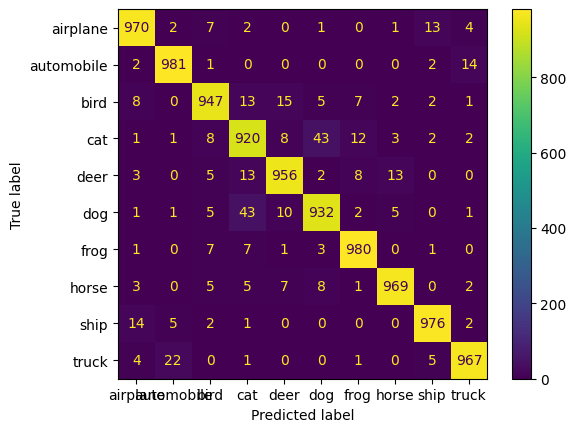

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_confusion_matrix(network):
  # compute predictions and collect targets
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  y_pred, y_test = [], []
  network.eval()
  with torch.no_grad():
    for features, targets in testloader:
      features, targets = features.to(device), targets.to(device)
      pred = network(features) # feed network
      res = (torch.max(torch.exp(pred), 1)[1]).cpu().numpy()
      y_pred.extend(res)
      y_test.extend(targets.cpu().numpy())

  # compute confusion matrix
  matrix = confusion_matrix(y_test, y_pred)

  # plot confusion matrix
  labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
  disp.plot()
  plt.show()

plot_confusion_matrix(network_1)

In [ ]:
plot_confusion_matrix(network_2)